In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.utils.extmath import safe_sparse_dot, squared_norm
from scipy.misc import comb, logsumexp 
from sklearn.linear_model.logistic import _multinomial_grad_hess

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [720]:
from stratified_bayesian_optimization.lib.util import (
    separate_numpy_arrays_in_lists,
    wrapper_fit_gp_regression,
    get_default_values_kernel,
    get_number_parameters_kernel,
    combine_vectors,
    separate_vector,
    wrapper_GPFittingGaussian,
    wrapper_objective_acquisition_function,
    wrapper_gradient_posterior_mean_gp_model,
    wrapper_posterior_mean_gp_model,
    wrapper_optimize,
    wrapper_sgd,
    wrapper_evaluate_gradient_sample_params_gp,
)

In [159]:
from stratified_bayesian_optimization.lib.la_functions import (
    cholesky,
    cho_solve,
)

In [2]:
from scipy.stats import norm

In [3]:
mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
y = mnist.target

In [4]:
train_samples = 30000

In [5]:
random_state = check_random_state(0)

permutation = random_state.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000, random_state=1)

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
Y_train = np.zeros((len(y_train), 10))
for i,j in enumerate(y_train):
    Y_train[i, int(j)] = 1

In [8]:
Y_test = np.zeros((len(y_test), 10))
for i,j in enumerate(y_test):
    Y_test[i, int(j)] = 1

In [38]:
def loss_function(X,Y, w, alpha=0):
    n_classes = Y.shape[1]
    n_features = X.shape[1]
    w = w.reshape(n_classes, -1)
    fit_intercept = w.size == (n_classes * (n_features + 1))
    old_w = w.copy()
    if fit_intercept:
        intercept = w[:, -1]
        w = w[:, :-1]
    else:
        intercept = 0
    p = safe_sparse_dot(X, w.T)
    p += intercept
    
    p -= logsumexp(p, axis=1)[:, np.newaxis]
    loss = -(Y * p).sum()
    loss += 0.5 * alpha * squared_norm(w)
    p = np.exp(p, p)
    return loss, p, w
    

In [10]:
def grad_loss(X, Y, w, alpha=0):
    n_classes = Y.shape[1]
    n_features = X.shape[1]
    fit_intercept = (w.size == n_classes * (n_features + 1))
    grad = np.zeros((n_classes, n_features + bool(fit_intercept)),
                    dtype=X.dtype)
    loss, p, w = loss_function(X, Y, w,alpha)
    diff = (p - Y)
    grad[:, :n_features] = safe_sparse_dot(diff.T, X)
    grad[:, :n_features] += alpha * w
    if fit_intercept:
        grad[:, -1] = diff.sum(axis=0)
    return loss, grad.ravel(), p

In [56]:
def compute_accuracy(X,Y,w):
    n_classes = Y.shape[1]
    n_features = X.shape[1]
    w = w.reshape(n_classes, -1)
    fit_intercept = w.size == (n_classes * (n_features + 1))
    old_w = w.copy()
    if fit_intercept:
        intercept = w[:, -1]
        w = w[:, :-1]
    else:
        intercept = 0
    p = safe_sparse_dot(X, w.T)
    p += intercept
    indices = p.argmax(axis=1)
    equal = Y_train.argmax(axis=1) == indices
    accuracy = np.sum(equal)
    return accuracy / float(Y_train.shape[0])
    

In [11]:
import math

In [12]:
fit_intercept = True
n_features = X_train.shape[1]
n_classes = 10
pairs_tr = X_train.shape[0]

array([ 6.,  4.,  7., ...,  2.,  9.,  2.])

In [63]:
def sgd(momentum=0.9, lr=0.01, batch_size=1001, alpha=4.64711970025, maxepoch=20, adam=False, betas=None, eps=1e-8,
       w0=None):
    pairs_tr = X_train.shape[0]
    if betas is None:
        betas = (0.9, 0.999)
    if w0 is None:
        w0 = np.zeros((n_classes, n_features + int(fit_intercept)),
                      order='F', dtype=X.dtype)
        np.random.seed(1)
        w0 = 0.1 * np.random.randn(n_classes, n_features + int(fit_intercept))
        w0 = w0.ravel() 
    v = np.zeros(len(w0))
    num_batches = int(math.ceil(pairs_tr / float(batch_size)))
    m0 = np.zeros(len(w0))
    v0 = np.zeros(len(w0))
    t_ = 0
    
    loss_vect = []
    loss_,g,p_ = grad_loss(X_train,Y_train,w0,alpha)
    trajectory_x = []
    trajectory_v = []
    trajectory_x.append(w0)
    trajectory_v.append(v)
    loss_vect.append(-1.0 * loss_)
    
    train_accuracy = []
    r = compute_accuracy(X_train,Y_train,w0)
    train_accuracy.append(r)
    
    for epoch in range(0, maxepoch):
        shuffled_order = np.arange(pairs_tr)
        np.random.shuffle(shuffled_order)
        previous = w0.copy()
        for batch in range(num_batches):
            t_ += 1
            next_ = min(batch_size * (batch + 1), pairs_tr)
            batch_idx = np.arange(batch_size * batch, next_)
            res = batch_size * (batch + 1) - next_
            if res > 0:
                extra = np.arange(0, res)
                batch_idx = np.concatenate((extra, batch_idx))
            batch_x = np.array(X_train[shuffled_order[batch_idx],:])  
            batch_y = np.array(Y_train[shuffled_order[batch_idx],:])
            loss_,g,p_ = grad_loss(batch_x,batch_y,w0,alpha)
            old_w = w0.copy()
            g = g / float(batch_size)
            if not adam:
                old_v = v.copy()
                v = momentum * v + g
                increament = - lr
                w0 = w0 - lr * v
            else:
                increament = 0.0
                m0 = betas[0] * m0 + (1 - betas[0]) * g
                v0 = betas[1] * v0 + (1 - betas[1]) * ((g) ** 2)
                m_1 = m0 / (1 - (betas[0]) ** (t_))
                v_1 = v0 / (1 - (betas[1]) ** (t_))
                w0 = w0 - lr * m_1 / (np.sqrt(v_1) + eps)
        trajectory_x.append(w0)
        trajectory_v.append(v)       
        loss_,g,p_ = grad_loss(X_train,Y_train,w0,alpha)
        loss_vect.append(-1.0 * loss_)
        #den_norm = (np.sqrt(np.sum(previous ** 2)))
        r = compute_accuracy(X_train,Y_train,w0)
        train_accuracy.append(r)

    loss, grad_l, p = grad_loss(X_test, Y_test, w0, alpha=0)

#    r = compute_accuracy(X_train,Y_train,w0)
    
    return w0,loss/float(X_test.shape[0]), train_accuracy, train_accuracy, trajectory_x, trajectory_v

In [64]:
starting_points={}
n_sp = 10
for i in range(n_sp): 
    w0 = np.zeros((n_classes, n_features + int(fit_intercept)),
                  order='F', dtype=X.dtype)
    np.random.seed(i)
    w0 = 10 ** (- i + 4)  * np.random.randn(n_classes, n_features + int(fit_intercept))
    w0 = w0.ravel() 
    starting_points[i] = w0

In [65]:
results = {}
trajectory_x = {}
trajectory_v = {}
for i in range(n_sp):
    l=sgd(w0=starting_points[i])
    results[i] = l[-3]
    trajectory_x[i] = l[-2]
    trajectory_v[i] = l[-1]

In [490]:
results

{0: [0.082400000000000001,
  0.082400000000000001,
  0.082433333333333331,
  0.082433333333333331,
  0.082433333333333331,
  0.082433333333333331,
  0.082500000000000004,
  0.082433333333333331,
  0.082566666666666663,
  0.082633333333333336,
  0.082566666666666663,
  0.082533333333333334,
  0.082633333333333336,
  0.082666666666666666,
  0.082600000000000007,
  0.082766666666666669,
  0.082799999999999999,
  0.082766666666666669,
  0.082799999999999999,
  0.082866666666666672,
  0.082766666666666669],
 1: [0.11623333333333333,
  0.11626666666666667,
  0.11656666666666667,
  0.1167,
  0.11696666666666666,
  0.11726666666666667,
  0.11746666666666666,
  0.11763333333333334,
  0.11776666666666667,
  0.11796666666666666,
  0.11806666666666667,
  0.1183,
  0.11853333333333334,
  0.11873333333333333,
  0.11899999999999999,
  0.11913333333333333,
  0.11926666666666667,
  0.11953333333333334,
  0.11966666666666667,
  0.1198,
  0.11993333333333334],
 2: [0.11559999999999999,
  0.11693333333333

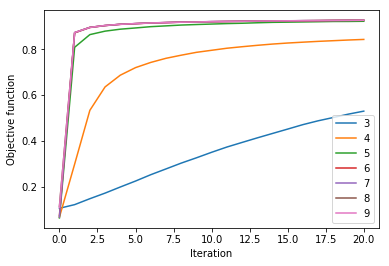

In [68]:
plt.figure()
x_lim = len(results[0])
points = range(x_lim)
for i in range(3,n_sp):
    plt.plot(points, results[i][0:x_lim],label=str(i))
    
plt.legend()
plt.ylabel('Objective function')
plt.xlabel('Iteration')

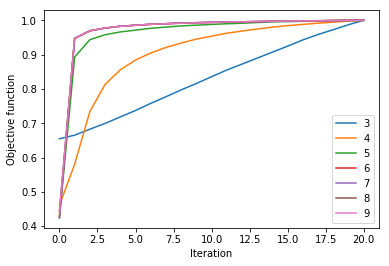

In [73]:
plt.figure()
x_lim = len(results[0])
points = range(x_lim)
for i in range(3,n_sp):
    plt.plot(points, [np.exp(-(results[i][-1] - t)) for t in results[i][0:x_lim]],label=str(i))
    
plt.legend()
plt.ylabel('Objective function')
plt.xlabel('Iteration')

### Process data

In [837]:
points = [2, 5, 9]

In [838]:
raw_results = {}
for j in points:
    raw_results[j] = [results[j][i] for i in range(3)]
    raw_results[j] = [results[j][i] for i in range(3)]
    raw_results[j] = [results[j][i] for i in range(3)]

In [839]:
raw_results

{2: [0.11559999999999999, 0.11693333333333333, 0.11923333333333333],
 5: [0.064166666666666664, 0.80846666666666667, 0.86373333333333335],
 9: [0.11043333333333333, 0.87276666666666669, 0.89506666666666668]}

In [840]:
best_results = {}
for j in points:
    best_results[j] = np.max(raw_results[j])

In [841]:
current_iterations = {}
for j in points:
    current_iterations[j] = 3

In [848]:
differences = {}
for j in points:
    differences[j] = []
    for i in range(1, len(raw_results[j])):
        diff = raw_results[j][i] - raw_results[j][i-1]
        differences[j].append(diff)

In [843]:
points_differences = {}
for j in points:
    points_differences[j] = []
    for i in range(1, len(raw_results[j])):
        points_differences[j].append((i, i+1))

In [853]:
training_data = {}
for j in points:
    training_data[j] = {}
    training_data[j]['points'] = [[2.], [3.]]
    training_data[j]['evaluations'] = list(differences[j])
    training_data[j]['var_noise'] = []

### Define GP model

In [500]:
import sys

In [501]:
sys.path.append('/Users/saultoscano/Documents/research/GitHub/stratified_bayesian_optimization')

In [502]:
from stratified_bayesian_optimization.lib.constant import (
    SCALED_KERNEL,
    MATERN52_NAME,
    TASKS_KERNEL_NAME,
    PRODUCT_KERNELS_SEPARABLE,
    UNIFORM_FINITE,
    SBO_METHOD,
    EI_METHOD,
    DOGLEG,
    MULTI_TASK_METHOD,
    EXPONENTIAL,
    SCALED_KERNEL,
    GAMMA,
    WEIGHTED_UNIFORM_FINITE,
    SDE_METHOD,
    LBFGS_NAME,
    ORNSTEIN_KERNEL,
)
from stratified_bayesian_optimization.services.gp_fitting import GPFittingService

In [503]:
def objective_function(x):
    return [np.sum(x[1:3])]

In [862]:
specs = {}
for i in points:
    spec = {
                'name_model': 'gp_fitting_gaussian',
                'problem_name': 'logistic',
                'type_kernel': [ORNSTEIN_KERNEL],
                'dimensions': [1],
                'bounds_domain': [[1,100]],
                'type_bounds': [0],
                'n_training': 10,
                'noise': False,
                'training_data': training_data[i],
                'points': None,
                'training_name': None,
                'mle': False,
                'thinning': 10,
                'n_burning': 500,
                'max_steps_out': 1000,
                'n_samples': 0,
                'random_seed': 1,
                'kernel_values': None,
                'mean_value': None,
                'var_noise_value': None,
                'cache': True,
                'same_correlation': True,
                'use_only_training_points': True,
                'optimization_method': 'SBO',
                'n_samples_parameters': 10,
                'parallel_training': False,
                'simplex_domain': None,
                'objective_function': objective_function,
                'define_samplers': False
    }
    specs[i] = spec

In [863]:
def create_gp_model_from_spec(spec, st_point):
    model = GPFittingService.from_dict(spec)
    model.dimension_parameters -= 2
    model.best_results = best_results[st_point]
    model.current_iterations = current_iterations[st_point]
    model.raw_results = list(raw_results[st_point])
    model.data['points'] = list(points_differences[st_point])
    return model

In [864]:
gp_models_no_mean = {}
for i in points:
    gp_models_no_mean[i] = create_gp_model_from_spec(specs[i], i)

INFO:stratified_bayesian_optimization.util.json_file:Loading data/gp_models/logistic/gp_GPFittingGaussian_logistic_Ornstein_kernel_default_training_data_10_points_rs_1.json
INFO:stratified_bayesian_optimization.services.gp_fitting:Training GPFittingGaussian
INFO:stratified_bayesian_optimization.util.json_file:Loading data/gp_models/logistic/gp_GPFittingGaussian_logistic_Ornstein_kernel_default_training_data_10_points_rs_1.json
INFO:stratified_bayesian_optimization.services.gp_fitting:Training GPFittingGaussian
INFO:stratified_bayesian_optimization.util.json_file:Loading data/gp_models/logistic/gp_GPFittingGaussian_logistic_Ornstein_kernel_default_training_data_10_points_rs_1.json
INFO:stratified_bayesian_optimization.services.gp_fitting:Training GPFittingGaussian


In [507]:
def covariance_diff_kernel(self, X, params):
    f = lambda x: np.sqrt(float(x))
    raw_x = []
    raw_x.append([X[0][0]])
    for t in X:
        raw_x.append([t[1]])
    raw_x = np.array(raw_x)
    raw_cov = self.kernel.evaluate_cov_defined_by_params(params, raw_x, 1)
    n= len(X)
    cov_mat = np.zeros((n, n))
    for i in range(n):
        diff = (raw_cov[i, i] / f(i + 1))  + (raw_cov[i+1, i+1] / f(i + 2))
        diff -= (2.0 * raw_cov[i, i+1] / f(i+2))
        cov_mat[i, i] = diff
        for j in range(i + 1, n):
            diff = (raw_cov[i, j] / f(j+1)) + (raw_cov[i+1, j+1] / f(j+2))
            diff -= ((raw_cov[i, j+1] / f(j+2)) + (raw_cov[i+1,j] / f(j+1)))
            cov_mat[i,j]= diff
            cov_mat[j,i]= diff
    return cov_mat

In [508]:
def log_likelihood(self, parameters_kernel):
    """
    GP log likelihood: y(x) ~ f(x) + epsilon, where epsilon(x) are iid N(0,var_noise), and
    f(x) ~ GP(mean, cov)

    :param var_noise: (float) variance of the noise
    :param mean: (float)
    :param parameters_kernel: np.array(k), The order of the parameters is given in the
        definition of the class kernel.
    :return: float

    """
    
    X_data = self.data['points']
    n = len(X_data)
    cov = covariance_diff_kernel(self, X_data, parameters_kernel)
    chol = cholesky(cov,  max_tries=7)
   
    y_unbiased = self.data['evaluations']
    solve = cho_solve(chol, y_unbiased)

    return -np.sum(np.log(np.diag(chol))) - 0.5 * np.dot(y_unbiased, solve)

In [509]:
log_likelihood(gp_model,params)

32.848152852156041

In [510]:
def log_prob(parameters, self):
        lp = 0.0
        parameters_model = self.get_parameters_model[2:]
        index = 0

        for parameter in parameters_model:
            dimension = parameter.dimension
            lp += parameter.log_prior(parameters[index: index + dimension])

            index += dimension
        if not np.isinf(lp):
            lp += log_likelihood(self, parameters)
            
        return lp


In [511]:
log_prob(params, gp_model)

array([ 30.58876667])

In [512]:
def sample_parameters(self, n_samples, start_point=None, random_seed=None):
    """
    Sample parameters of the model from the posterior without considering burning.

    :param n_samples: (int)
    :param start_point: np.array(n_parameters)
    :param random_seed: int

    :return: n_samples * [np.array(float)]
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    samples = []

    if start_point is None:
        start_point = self.samples_parameters[-1]


    n_samples *= (self.thinning + 1)
    n_samples = int(n_samples)

    if len(self.slice_samplers) == 1:
        for sample in xrange(n_samples):
            start_point_ = None
            n_try = 0
            points = start_point
           # points = separate_vector(start_point, self.length_scale_indexes)
            while start_point_ is None and n_try < 10:
                try:
                    start_point_ = \
                        self.slice_samplers[0].slice_sample(points, None, *(self, ))
                except Exception as e:
                    n_try += 1
                    start_point_ = None
            if start_point_ is None:
                logger.info('program failed to compute a sample of the parameters')
                sys.exit(1)
            start_point = start_point_
            samples.append(start_point)
        samples_return = samples[::self.thinning + 1]
        self.samples_parameters += samples_return
        return samples_return

    for sample in xrange(n_samples):
        points = separate_vector(start_point, self.length_scale_indexes)
        for index, slice in enumerate(self.slice_samplers):
            new_point_ = None
            n_try = 0
            while new_point_ is None and n_try < 10:
                try:
                    new_point_ = \
                        slice.slice_sample(points[1 - index], points[index], *(self, ))
                except Exception as e:
                    n_try += 1
                    new_point_ = None
            if new_point_ is None:
                logger.info('program failed to compute a sample of the parameters')
                sys.exit(1)
            points[1 - index] = new_point_
        start_point = combine_vectors(points[0], points[1], self.length_scale_indexes)
        samples.append(start_point)
    samples_return = samples[::self.thinning + 1]
    self.samples_parameters += samples_return

    return samples_return

In [513]:
from stratified_bayesian_optimization.samplers.slice_sampling import SliceSampling

In [514]:
def set_samplers(self):
    """
    Defines the samplers of the parameters of the model.
    We assume that we only have one set of length scale parameters.
    """
    self.slice_samplers = []
    self.samples_parameters = []
    self.start_point_sampler = []
    if self.length_scale_indexes is None:
        ignore_index = None

        slice_parameters = {
            'max_steps_out': self.max_steps_out,
            'component_wise': True,
        }
        self.slice_samplers.append(SliceSampling(
            log_prob, range(self.dimension_parameters),  ignore_index=ignore_index,
            **slice_parameters))
    else:
        slice_parameters = {
            'max_steps_out': self.max_steps_out,
            'component_wise': False,
        }
        indexes = [i for i in range(self.dimension_parameters) if i not in
                   self.length_scale_indexes]
        ignore_index = None
        if not self.noise or self.data.get('var_noise') is not None:
            ignore_index = [0, 1]

        if ORNSTEIN_KERNEL in self.type_kernel:
            if ignore_index is None:
                ignore_index = []
            ignore_index += [2]

        if len(indexes) != len(ignore_index):
            self.slice_samplers.append(
                SliceSampling(
                    log_prob, indexes, ignore_index=ignore_index, **slice_parameters))

        slice_parameters['component_wise'] = True
        self.slice_samplers.append(SliceSampling(wrapper_log_prob, self.length_scale_indexes,
                                                 **slice_parameters))

    if self.start_point_sampler is not None and len(self.start_point_sampler) > 0:
        if len(self.samples_parameters) == 0:
            self.samples_parameters.append(np.array(self.start_point_sampler))
    else:
        self.samples_parameters = []
        z = self.get_value_parameters_model
        z = z[2:]
        self.samples_parameters.append(z)
        if self.n_burning > 0:
            parameters = sample_parameters(self, float(self.n_burning) / (self.thinning + 1))
            self.samples_parameters = []
            self.samples_parameters.append(parameters[-1])
            self.start_point_sampler = parameters[-1]
        else:
            self.start_point_sampler = self.get_value_parameters_model

In [515]:
for i in points:
    print i
    set_samplers(gp_models_no_mean[i])

2
5
9


In [413]:
set_samplers(gp_model_2)

## Posterior parameters

In [516]:
def cov_diff_point(self, params, x, X):
    f = lambda x: np.sqrt(float(x))
    z = np.array([x])
    
    raw_x = []
    raw_x.append([X[0][0]])
    for t in X:
        raw_x.append([t[1]])
        
    raw_x = np.array(raw_x)
    raw_cov = self.kernel.evaluate_cross_cov_defined_by_params(params, z, raw_x, 1)
    
    cov = np.zeros(len(X))
    for i in range(len(X)):
        cov[i] = (raw_cov[0, i] - raw_cov[0, i+1]) / f(x[0])
        
    return cov 

In [517]:
def compute_posterior_params(self, params):
    ## Mean is zero. We may need to change when including mean
    ##Compute posterior parameters of f(x*)
    f = lambda x: np.sqrt(float(x))
    current_point = [self.current_iterations]
    X_data = self.data['points']
    vector_ = cov_diff_point(self, params, current_point, X_data)
    
    cov = covariance_diff_kernel(self, X_data, params)
    chol = cholesky(cov,  max_tries=7)
 
    y_unbiased = self.data['evaluations']
    solve = cho_solve(chol, y_unbiased)
    
    part_2 = cho_solve(chol, vector_)
    

    mean =  self.raw_results[-1] + np.dot(part_2, solve)
    
    raw_cov = self.kernel.evaluate_cov_defined_by_params(params, np.array([current_point]), 1) / f(current_point[0]) 
    
    var = raw_cov - np.dot(part_2, part_2)
    
    return mean, var

In [461]:
mean, cov = compute_posterior_params(gp_model, gp_model.samples_parameters[-1])

In [351]:
def compute_posterior_params_marginalize(self, n_samples=10, burning_parameters=True):
    
    if burning_parameters:
        parameters = sample_parameters(self, float(self.n_burning) / (self.thinning + 1))
        self.samples_parameters = []
        self.samples_parameters.append(parameters[-1])
        self.start_point_sampler = parameters[-1]
        
    parameters = sample_parameters(self, n_samples)
    
    means = []
    covs = []
    for param in parameters:
        mean, cov = compute_posterior_params(self, param)
        means.append(mean)
        covs.append(cov)
        
    mean = np.mean(means)
    std = np.sqrt(np.mean(covs))
    
    ci = [mean-1.96 * std, mean+ 1.96*std]
    
    return mean, std, ci
        

### Accuracy of models

In [ ]:
raw_results = {}
for j in points:
    raw_results[j] = [results[j][i] for i in range(3)]
    raw_results[j] = [results[j][i] for i in range(3)]
    raw_results[j] = [results[j][i] for i in range(3)]

In [326]:
def add_observations(self, point, y, previous_y):
    self.current_iterations = point
    self.raw_results.append(y)
    self.best_results = max(self.best_results, y)
    self.data['points'].append((point-1, point))
    self.data['evaluations'] = np.concatenate((self.data['evaluations'],[(y - previous_y)]))
    return self

In [469]:
def accuracy(self, st_point, iterations=21, start=3):
    means = []
    cis = []
    
    
    mean, std, ci = compute_posterior_params_marginalize(self)
    means.append(mean)
    cis.append(ci)
    
    for i in range(start, iterations):
        print (i)
        self = add_observations(self, i + 1, results[st_point][i], results[st_point][i-1])
        mean, std, ci = compute_posterior_params_marginalize(self)
        means.append(mean)
        cis.append(ci)
    return means, cis
    

In [477]:
def plot_means(means, cis, original_value, start=3):
    plt.figure()
    x_lim = len(means)
    points = range(start, x_lim + start)
    plt.plot(points, means,'b')
    plt.plot(points, len(points) * [original_value], 'r')
    plt.plot(points, [t[0] for t in cis],'g-')
    plt.plot(points, [t[1] for t in cis],'g-')

    plt.legend()
    plt.ylabel('Objective function')
    plt.xlabel('Iteration')

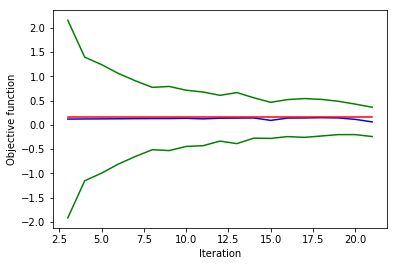

In [478]:
plot_means(means,cis, results[2][-1])

In [468]:
means, cis = accuracy(gp_model, 2)

3
her
0.121199058516 [-1.1536002309709898, 1.3959983480028377]
4
her
0.123305994765 [-0.99538674449386155, 1.2419987340237899]
5
her
0.125476150574 [-0.80773621272229534, 1.0586885138708522]
6
her
0.128315711901 [-0.65154897541101298, 0.90818039921204996]
7
her
0.130098409824 [-0.51277902080683924, 0.77297584045392642]
8
her
0.13061562731 [-0.53075673018900926, 0.7919879848089002]
9
her
0.134485797447 [-0.44517562422967183, 0.71414721912366019]
10
her
0.123605564096 [-0.43028880383531459, 0.67749993202775438]
11
her
0.136900328332 [-0.33535208160718744, 0.60915273827170302]
12
her
0.139009059471 [-0.38733752283141298, 0.66535564177419004]
13
her
0.142027284875 [-0.27451124217550377, 0.55856581192560983]
14
her
0.0922258150234 [-0.279783943435298, 0.46423557348212929]
15
her
0.139593063102 [-0.24230122386485387, 0.52148735006827107]
16
her
0.142045320844 [-0.25812967719953089, 0.54222031888762756]
17
her
0.147654833139 [-0.2294970812963249, 0.52480674757476398]
18
her
0.142476627945 [-0

# Parametric mean!!!

## Interpolation functions

In [542]:
def linear(x, a, b):
    x = float(x)
    a = float(a)
    b = float(b)
    
    return a * x + b

def grad_linear(x,a,b):
    x = float(x)
    a = float(a)
    b = float(b)
  
    grad = np.zeros(2)
    
    grad[0] = x
    grad[1] = 1.0
 
    return grad

In [518]:
def vapor_pressure(x, a, b, c):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    
    return np.exp(a + (b / x) + c * np.log(x))

def grad_vapor_pressure(x,a,b,c):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    
    grad = np.zeros(3)
    value = vapor_pressure(x, a, b, c)
    
    grad[0] = value
    grad[1] = value * (1.0 / x)
    grad[2] = value * np.log(x)
        
    
    return grad

In [520]:
def pow_3(x, a, c, alpha):
    x = float(x)
    a = float(a)
    alpha = float(alpha)
    c = float(c) 
    
    val = c - a * (np.power(x, -1.0 * alpha))
    

    
    return val

def grad_pow_3(x, a, c, alpha):
    x = float(x)
    a = float(a)
    alpha = float(alpha)
    c = float(c) 
    
    grad = np.zeros(3)
    grad[0] = -np.power(x, -1.0 * alpha)
    grad[1] = 1.0
    grad[2] = a * (np.power(x, -1.0 * alpha)) * np.log(x)
    

    return grad
    

In [ ]:
d={'a': 1.1098132161448053, 'alpha': 0.57295007091643357, 'c': 0.261028854159291}

In [521]:
def log_log_linear(x, a, b):
    x = float(x)
    a = float(a)
    b = float(b)

    return np.log(a * np.log(x) + b)

def grad_log_log_linear(x, a, b):
    x = float(x)
    a = float(a)
    b = float(b)
    
    grad = np.zeros(2)
    grad[0] = np.log(x) / (a * np.log(x) + b)
    grad[1] = 1.0 / (a * np.log(x) + b)

    return grad

In [522]:
def hill_3(x, eta, k, theta, alpha):
    x = float(x)
    eta = float(eta)
    k = float(k)
    theta = float(theta)
    alpha = float(alpha)
    
    return alpha + (theta * np.power(x, eta)) / (np.power(k, eta) + np.power(x, eta))

def grad_hill_3(x, eta, k, theta, alpha):
    x = float(x)
    eta = float(eta)
    k = float(k)
    theta = float(theta)
    alpha = float(alpha)
    
    grad = np.zeros(4)
    grad[0] = theta * (np.power(k, eta) * (np.power(k, eta) + np.power(x, eta)) * np.log(x) - np.power(x, eta) * (np.power(k, eta) * np.log(k) + np.power(x, eta) * np.log(x))) / ((np.power(k, eta) + np.power(x, eta)) ** 2)
    grad[1] = - (theta * np.power(x, eta) * np.power(k, eta-1) * eta) / ((np.power(k, eta) + np.power(x, eta)) ** 2)
    grad[2] = (np.power(x, eta)) / (np.power(k, eta) + np.power(x, eta))
    grad[3] = 1.0
    return grad

In [523]:
def log_power(x, a, b ,c):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    
    return a / (1.0 + np.power((x / np.exp(b)), c))

def grad_log_power(x, a, b ,c):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    
    grad = np.zeros(3)
    
    grad[0] = 1.0 / (1.0 + np.power((x / np.exp(b)), c))
    grad[1] = (a * np.power((x / np.exp(b)), c) *  c) / ((1.0 + np.power((x / np.exp(b)), c)) ** 2)
    grad[2] = (- a * np.power((x / np.exp(b)), c) *  (np.log(x) - b)) / ((1.0 + np.power((x / np.exp(b)), c)) ** 2)
    
    return grad

In [524]:
def pow_4(x, a, b ,c, alpha):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    alpha = float(alpha)
    
    return c - np.power(a * x + b, -1.0*alpha)

def grad_pow_4(x, a, b ,c, alpha):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    alpha = float(alpha)
    
    grad = np.zeros(4)
    
    grad[0] = alpha * x * np.power(a * x + b, -1.0*alpha) / (a * x + b)
    grad[1] = alpha * np.power(a * x + b, -1.0*alpha) / (a * x + b)
    grad[2] = 1.0
    grad[3] = np.power(a * x + b, -1.0*alpha) * np.log(a * x + b)
    
    return grad

In [677]:
d={'a': 135.78110609631275, 'alpha': 0.14096454463848812, 'c': 1.0000009999999999, 'b': -444.54248022781883}

In [679]:
np.power(135.0-444,-1.0*1e-10)

/Users/saultoscano/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


nan

In [678]:
pow_4(1,**d)

/Users/saultoscano/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power


nan

In [525]:
def mmf(x, alpha, beta, k, delta):
    x = float(x)
    alpha = float(alpha)
    beta = float(beta)
    k = float(k)
    delta = float(delta)
    
    return alpha - ((alpha - beta) / (1.0 + np.power(k*x,delta)))

def grad_mmf(x, alpha, beta, k, delta):
    x = float(x)
    alpha = float(alpha)
    beta = float(beta)
    k = float(k)
    delta = float(delta)
    
    grad = np.zeros(4)
    
    grad[0] = 1.0 - 1.0 / ((1.0 + np.power(k*x,delta)))
    grad[1] = 1.0 /  ((1.0 + np.power(k*x,delta)))
    grad[2] = (alpha - beta) * np.power(k*x,delta) * delta * (1.0 / k) / (((1.0 + np.power(k*x,delta)))**2)
    grad[3] = (alpha - beta) * np.power(k*x,delta) * np.log(k*x)/ (((1.0 + np.power(k*x,delta)))**2)
    
    return grad

In [526]:
def exp_4(x, a, b, c, alpha):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    alpha = float(alpha)
    
    
    return c - np.exp(b - a * np.power(x, alpha))
    
def grad_exp_4(x, a, b, c, alpha):
    x = float(x)
    a = float(a)
    b = float(b)
    c = float(c)
    alpha = float(alpha)
    
    grad = np.zeros(4)
    
    grad[0] = - np.exp(b - a * np.power(x, alpha)) * (- np.power(x, alpha))
    grad[1] = - np.exp(b - a * np.power(x, alpha))
    grad[2] = 1.0
    grad[3] =  a * np.power(x, alpha) * np.log(x) * np.exp(b - a * np.power(x, alpha))
    
    return grad
    

In [663]:
d={'a': 0.6848095987297137, 'alpha': 0.4465773916156186, 'c': 0.2, 'b': -0.63425983343071968}

In [664]:
exp_4(1,**d)

-0.06738400518633475

In [527]:
def janoschek(x, alpha, beta, k, delta):
    x = float(x)
    alpha = float(alpha)
    beta = float(beta)
    k = float(k)
    delta = float(delta)
    
    return alpha - (alpha - beta) * np.exp(-k * np.power(x, delta))
    
def grad_janoschek(x, alpha, beta, k, delta):
    x = float(x)
    alpha = float(alpha)
    beta = float(beta)
    k = float(k)
    delta = float(delta)
    
    grad = np.zeros(4)
    
    grad[0] = 1.0 - np.exp(-k * np.power(x, delta))
    grad[1] = np.exp(-k * np.power(x, delta))
    grad[2] =  (alpha - beta) * np.exp(-k * np.power(x, delta)) * np.power(x, delta)
    grad[3] = (alpha - beta) * np.exp(-k * np.power(x, delta)) * k * np.power(x, delta) * np.log(x)
    
    return grad
    

In [528]:
def weibull(x, alpha, beta, k, delta ):
    x = float(x)
    alpha = float(alpha)
    beta = float(beta)
    k = float(k)
    delta = float(delta)
    
    return alpha - (alpha - beta) * np.exp(- np.power(k * x, delta))
   
    
def grad_weibull(x, alpha, beta, k, delta ):
    x = float(x)
    alpha = float(alpha)
    beta = float(beta)
    k = float(k)
    delta = float(delta)
    
    grad = np.zeros(4)
    
    grad[0] = 1.0 - np.exp(- np.power(k * x, delta))
    grad[1] = np.exp(- np.power(k * x, delta))
    grad[2] = (alpha - beta) * np.exp(- np.power(k * x, delta)) * np.power(k * x, delta) * delta * (1.0 / k)
    grad[3] = (alpha - beta) * np.exp(- np.power(k * x, delta)) * np.power(k * x, delta) * np.log(k * x)
    
    return grad
   
    

In [529]:
def ilog2(x, a ,c):
    x = float(x)
    a = float(a)
    c = float(c)
    return c - (a / np.log(x + 1))

def grad_ilog2(x, a ,c):
    x = float(x)
    a = float(a)
    c = float(c)
    
    grad = np.zeros(2)
    grad[0] = -1.0 / (np.log(x+1))
    grad[1] = 1.0
    return grad

In [709]:
d={'a': 0.85966792742057863, 'c': 0.67924682489559396}
ilog2(1,**d)

-0.56099183080536819

In [714]:
0.6 *np.log(2)

0.41588830833596718

In [543]:
functions = {
    'linear': linear,
    'ilog2': ilog2,
    'weibull': weibull,
    'janoschek': janoschek,
    'exp_4': exp_4,
    'mmf': mmf,
    'pow_4': pow_4,
    'log_power': log_power,
    'hill_3': hill_3,
    'log_log_linear': log_log_linear,
    'pow_3': pow_3,
    'vapor_pressure': vapor_pressure,  
}

In [544]:
gradients_functions = {
    'linear': grad_linear,
    'ilog2': grad_ilog2,
    'weibull': grad_weibull,
    'janoschek': grad_janoschek,
    'exp_4': grad_exp_4,
    'mmf': grad_mmf,
    'pow_4': grad_pow_4,
    'log_power': grad_log_power,
    'hill_3': grad_hill_3,
    'log_log_linear': grad_log_log_linear,
    'pow_3': grad_pow_3,
    'vapor_pressure': grad_vapor_pressure,   
}

In [545]:
list_functions = functions.keys()
list_functions

['linear',
 'hill_3',
 'vapor_pressure',
 'mmf',
 'janoschek',
 'log_power',
 'log_log_linear',
 'weibull',
 'exp_4',
 'pow_4',
 'pow_3',
 'ilog2']

In [533]:
parameters_functions = {
    'linear': ['a', 'b'],
    'ilog2': ['a', 'c'],
    'weibull': ['alpha', 'beta', 'k', 'delta'],
    'janoschek': ['alpha', 'beta', 'k', 'delta'],
    'exp_4': ['a', 'b', 'c', 'alpha'],
    'mmf': ['alpha', 'beta', 'k', 'delta'],
    'pow_4': ['a', 'b', 'c', 'alpha'],
    'log_power': ['a', 'b', 'c'],
    'hill_3': ['eta', 'k', 'theta', 'alpha'],
    'log_log_linear': ['a', 'b'],
    'pow_3': ['a', 'c', 'alpha'],
    'vapor_pressure': ['a', 'b', 'c'], 
}

In [715]:
default_values = {
    'linear': [0.5, 0.5],
    'ilog2': [0.40999, 0.78],
    'weibull': [.7, 0.1, 0.01, 1],
    'janoschek': [0.73, 0.07,  0.355,  0.46],
    'exp_4': [0.8, -0.8,0.7, 0.3],
    'mmf': [.7,  0.1, 0.01,  5],
    'pow_4': [200, 0., 1.001,  0.1],
    'log_power': [0.77,  2.98, -0.51],
    'hill_3': [0.586449, 2.460843, 0.772320, 0.1],
    'log_log_linear': [1.0, 1.00001],
    'pow_3':[0.52, 0.84, 0.01],
    'vapor_pressure': [-0.622028, -0.470050,  0.042322],  
}


In [716]:
min_values = {
    'linear': [0.00001, 0.0001],
    'ilog2': [None, 0.6],
    'weibull': [None,None, 1e-10, None],
    'janoschek': [0.000001, 0.000001, None, None],
    'exp_4': [0.5, None,1.0, None],
    'mmf': [None, None, 1e-10, None],
    'pow_4': [None, 0., 1.000001, 1e-10],
    'log_power': [0.0000001, None, None],
    'hill_3': [-10.,1e-10, 1e-10, 1e-10],
    'log_log_linear': [1e-10,1.000001],
    'pow_3':[None, 0.60, None],
    'vapor_pressure': None,  
    
}

In [717]:
max_values = {
    'linear': None,
    'ilog2': [0.41, None],
    'weibull': None,
    'janoschek': None,
    'exp_4':  [None, 0.3,None, 1.5],
    'mmf': None,
    'pow_4': None,
    'log_power': None,
    'hill_3': [10.,None, 100., None],
    'log_log_linear':None,
    'pow_3':[0.59999,None , None],
    'vapor_pressure': None,  
    
}

In [538]:
n_parameters = 0
for f in list_functions:
    n_parameters += len(parameters_functions[f])
n_parameters

39

In [830]:
n_parameters+12

51

In [546]:
list_functions

['linear',
 'hill_3',
 'vapor_pressure',
 'mmf',
 'janoschek',
 'log_power',
 'log_log_linear',
 'weibull',
 'exp_4',
 'pow_4',
 'pow_3',
 'ilog2']

In [834]:
def weighted_combination(x, weights, params):
    """
    weights: [float]
    params: [float], they are in the order given by list_functions
    """
    copy_= list(params)
    val = 0.0
    
    
    for index_f, funct in enumerate(list_functions):
        function = functions[funct]
        parameters = parameters_functions[funct]
        
        n_params = len(parameters)
        par = params[0: n_params]
        params = params[n_params:]
        
        param_tmp = {}
   
        for index, p in enumerate(parameters):
            
            param_tmp[p] = par[index]
        val += weights[index_f] * function(x, **param_tmp)
        if val!=val:
            print function
            print x, param_tmp
            df

    return val

In [548]:
w=np.ones(12)
par = np.ones(n_parameters)
weighted_combination(1, w, par)

14.677419636671692

### Prior and posterior.
### I'm including sqrt(n) in the mean. So, Ln|Xn-X*| follws a gp with mean (1/sqrt(n))(-log(f(n, params)))

In [550]:
total_iterations = 20

In [571]:
def log_likelihood_mean(self, parameters_kernel, params_mean, weights):
    """
    GP log likelihood: y(x) ~ f(x) + epsilon, where epsilon(x) are iid N(0,var_noise), and
    f(x) ~ GP(mean, cov)

    :param var_noise: (float) variance of the noise
    :param mean: (float)
    :param parameters_kernel: np.array(k), The order of the parameters is given in the
        definition of the class kernel.
    :return: float

    """
    f = lambda r: np.sqrt(float(r))
    X_data = self.data['points']
    n = len(X_data)
    cov = covariance_diff_kernel(self, X_data, parameters_kernel)
    chol = cholesky(cov,  max_tries=7)
    
    mean_vector = np.zeros(len(X_data))
    for i in range(len(mean_vector)):
        mean_ = -np.log(weighted_combination(i+1,weights, params_mean)) / f(i+1)
        mean_ -= -np.log(weighted_combination(i+2,weights, params_mean)) / f(i+2)
        mean_vector[i] = mean_

    y_unbiased = self.data['evaluations'] - mean_vector
    solve = cho_solve(chol, y_unbiased)

    return -np.sum(np.log(np.diag(chol))) - 0.5 * np.dot(y_unbiased, solve)

In [921]:
def log_prob_with_mean(x,self, total_iterations=total_iterations,lower=np.exp(-1.0), upper=1.04):
    """
    log_prob for only one starting point
    Historical data of only one starting point.
    
    x[0:kernel_params] are the kenrel params
    then we have the weights, and then the parameters of te functions
    historical_data: [float]
    """
   
    bounds = []
   
#     print "params"
#     print x
    index = 0
    for f in list_functions:
        if min_values[f] is not None or max_values[f] is not None:
            bd = []
            if min_values[f] is not None:
                n_bounds = len(min_values[f])
            else:
                n_bounds = len(max_values[f])
            
            for i in range(n_bounds):
                bd_ = [None, None]
                if min_values[f] is not None:
                    bd_[0] =  min_values[f][i]
                if max_values[f] is not None:
                    bd_[1] = max_values[f][i]
                bd += [bd_]
            bounds += bd
            
        else:
            bd = len(parameters_functions[f]) * [[None, None]]
            bounds += bd
            
                    
    n_functions = len(list_functions)
    
    dim_kernel_params = self.dimension_parameters
    kernel_params = x[0:dim_kernel_params]
    weights = np.array(x[dim_kernel_params:n_functions+dim_kernel_params])
    
    if np.any(weights <= 0):
      #  print "weights"
        return -np.inf
    weights = weights / np.sum(weights)
    params =  x[n_functions+dim_kernel_params:]
    
   
    for i in range(n_functions+dim_kernel_params, len(x)):       
        if bounds[i - n_functions -dim_kernel_params][0] is not None and x[i] < bounds[i - n_functions -dim_kernel_params][0]:
#             print "wrong_bo"
            return -np.inf
        if bounds[i - n_functions - dim_kernel_params][1] is not None and x[i] > bounds[i - n_functions -dim_kernel_params][1]:
#             print "wrong_bo"
            return -np.inf
    if np.any(weights <= 0):
#         print "negative weights"
        return -np.inf

    if weighted_combination(1,weights, params) >= weighted_combination(total_iterations,weights, params):
#         print "no incease"
        return -np.inf
    
        
    if lower is not None and weighted_combination(1,weights, params) < lower:
       # print "no lower"
        return - np.inf
    if upper is not None and weighted_combination(total_iterations,weights, params) > upper:
       # print "no upper"
       # print weighted_combination(total_iterations,weights, params)
#         print weighted_combination(1,weights, params)
#         print weights
        return -np.inf
    
    lp = 0.0
    parameters_model = self.get_parameters_model[2:]
    index = 0

    for parameter in parameters_model:
        dimension = parameter.dimension
        lp += parameter.log_prior(kernel_params[index: index + dimension])
        index += dimension

    if not np.isinf(lp):
        lp += log_likelihood_mean(self, kernel_params, params, weights)
#     print "llllh"
#     print lp
#     print kernel_params, params, weights
    return lp

In [728]:
w=np.ones(12)
par = np.ones(n_parameters)
params_kernel = gp_model.start_point_sampler
x_params = np.concatenate((w, par, params_kernel))
log_prob_with_mean(x_params, gp_model)

-inf

In [914]:
def log_prob_per_function(x, historical_data, function_name, weight=1.0):
    """
    log_prob for only one starting point
    Historical data of only one starting point.
    
    x: dictionary with arguments of function
    historical_data: [float]
    """
    f = lambda r: np.sqrt(float(r))
    
    function = functions[function_name]
    params = x
    n_iterations = len(historical_data)
    params_names = parameters_functions[function_name]  
    
    
    dom_x = range(1, len(historical_data) + 1)
    evaluations = np.zeros(len(historical_data))
    for i in dom_x:
        first_1 = weight * function(i, **params)
        first_2 = weight * function(i+1, **params)
        val = -np.log(first_1) / f(i)
        val -= -np.log(first_2) / f(i+1)
        evaluations[i-1] =  val
    
    val = -1.0 * np.sum((evaluations - historical_data) ** 2) 

    return val

In [910]:
def gradient_llh_per_function(x, historical_data, function_name, weight=1.0):
    """
    Gradient of the llh respect to a specific function.
    
    :param function: str
    """
    f = lambda r: np.sqrt(float(r))
    function = functions[function_name]
    gradient_function = gradients_functions[function_name]
    params = x
    n_iterations = len(historical_data)
    
    bounds = []
    
    evaluations = np.zeros(len(historical_data))
    
    dom_x = range(1, len(historical_data) + 1)
    gradient_theta = np.zeros(len(x))
    for i in dom_x:     
        evaluations[i-1] = -np.log(weight * function(i, **params)) / f(i)
        evaluations[i-1] -= -np.log(weight * function(i+1, **params)) / f(i+1)
        tmp = - weight * gradient_function(i, **params) / (f(i) * weight * function(i, **params))
        tmp -= -weight * gradient_function(i+1, **params) / (f(i+1) * weight * function(i+1, **params))
        gradient_theta += tmp *  (evaluations[i-1] - historical_data[i-1])
        
    gradient_theta *= -2.0

    return gradient_theta
 

### Test Gradient

In [608]:
x = [ 0.52 , 0.84 , 0.01]
historical_data = gp_model.data['evaluations']
function_name = 'pow_3'

In [609]:
param_tmp = {}
params_names = parameters_functions[function_name]
for ind, name in enumerate(params_names):
    param_tmp[name] = x[ind]

param_tmp

{'a': 0.52, 'alpha': 0.01, 'c': 0.84}

In [610]:
gradient_llh_per_function(param_tmp, historical_data, function_name, weight=1.0)

array([ 0.59802425, -0.58703124,  0.57078713])

In [611]:
original = log_prob_per_function(param_tmp, historical_data, function_name)

In [612]:
dh = 0.0001
x = [ 0.52  , 0.84, 0.01 ]
x[1] +=dh
param_tmp = {}
params_names = parameters_functions[function_name]
for ind, name in enumerate(params_names):
    param_tmp[name] = x[ind]

new = log_prob_per_function(param_tmp, historical_data, function_name)
print (new - original) / dh


-0.587055368015


### MLE Estimator for parametric mean

In [605]:
from scipy.optimize import curve_fit, leastsq, fmin_bfgs, fmin_l_bfgs_b, nnls

In [915]:
def mle_params_per_function(historical_data, function_name, lower=np.exp(-1.0), upper=1.04, total_iterations=20):
    """
    log_prob for only one starting point
    
    :param historical_data: [float] 
    """
    historical_data = np.array(historical_data)
    n = len(historical_data)
    x = range(1, n + 1)
    function = functions[function_name]
    def objective(params):
        param_tmp = {}
        params_names = parameters_functions[function_name]
        for ind, name in enumerate(params_names):
            param_tmp[name] = params[ind]
        args_lp = list(params)
        val = log_prob_per_function(param_tmp, historical_data, function_name)
        return -1.0 * val

    def gradient(params):
        param_tmp = {}
        params_names = parameters_functions[function_name]
        for ind, name in enumerate(params_names):
            param_tmp[name] = params[ind]     
        val = gradient_llh_per_function(param_tmp, historical_data, function_name)
        
        for t in val:
            if t!=t:
                print "grad"
                print param_tmp
                print params
                print function_name
                df
        return -1.0 * val
    
    n_params_function = len(parameters_functions[function_name])
    
    params_st = np.ones(n_params_function)
    
    bounds = []
    
    if default_values[function_name] is not None:
        params_st[0:len(default_values[function_name])] = default_values[function_name]
        
        
    if min_values[function_name] is not None:
        bd = []
        for t in min_values[function_name]:
            bd += [[t, None]]
        bounds += bd
 
        
    if max_values[function_name] is not None:
        bd = []
        for it, t in enumerate(max_values[function_name]):
            if t is not None and len(bounds) > 0:
                bounds[it][1] = t
            elif len(bounds) == 0:
                bd += [[None, t]]
            
        if len(bounds) == 0:
            bounds += bd
          
    if max_values[function_name] is None and min_values[function_name] is None:
        bounds = len(default_values[function_name]) * [[None, None]]

    
    popt, fval, info= fmin_l_bfgs_b(objective,
                                    fprime=gradient,
                                x0=params_st,
                                bounds=bounds,
                                approx_grad=False)
    weight = 1.0
    param_tmp = {}
    params_names = parameters_functions[function_name]
    for ind, name in enumerate(params_names):
        param_tmp[name] = popt[ind]
        
    if lower is not None and function(1, **param_tmp) < lower:
        weight = lower / function(1, **param_tmp)
        
    if upper is not None and function(total_iterations,**param_tmp) > upper:
        weight = upper / function(total_iterations,**param_tmp)

    
    return popt, fval, info, weight

In [916]:
def get_starting_values(historical_data):
    st_weights=[]
    st_params=[]
    for function_n in list_functions:
        params_names = parameters_functions[function_n]
        result = mle_params_per_function(historical_data, function_n)
        st_params += list(result[0])
        st_weights.append(result[-1])
    st_weights = [t / np.sum(st_weights) for t in st_weights]
    start_params = st_weights + list(st_params) 
    start_params = np.array(start_params)
    
    return start_params

### ## Slice Sampling

In [700]:
len(list_functions)

12

In [919]:
def sample_parameters_mean(self, n_samples, start_point=None, random_seed=None):
    """
    Sample parameters of the model from the posterior without considering burning.

    :param n_samples: (int)
    :param start_point: np.array(n_parameters)
    :param random_seed: int

    :return: n_samples * [np.array(float)]
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    samples = []

    if start_point is None:
        start_point = self.samples_parameters[-1]


    n_samples *= (self.thinning + 1)
    n_samples = int(n_samples)



    for sample in range(n_samples):
        print "sample!!!!!"
        print sample
        points = separate_vector(start_point, range(self.dimension_parameters))
        for index, slice in enumerate(self.slice_samplers):
            new_point_ = None
            n_try = 0
            while new_point_ is None and n_try < 10:
                new_point_ = \
                    slice.slice_sample(points[index], points[1 - index], *(self, ))
                try:
                    new_point_ = \
                        slice.slice_sample(points[index], points[1 - index], *(self, ))
                except Exception as e:
                    n_try += 1
                    new_point_ = None
            if new_point_ is None:
                logger.info('program failed to compute a sample of the parameters')
                sys.exit(1)
            points[index] = new_point_
        start_point = combine_vectors(points[0], points[1], range(self.dimension_parameters))
        samples.append(start_point)
    samples_return = samples[::self.thinning + 1]
    self.samples_parameters += samples_return

    return samples_return

In [890]:
def set_samplers_mean(self):
    """
    Defines the samplers of the parameters of the model.
    We assume that we only have one set of length scale parameters.
    """
    self.slice_samplers = []
    self.samples_parameters = []
    self.start_point_sampler = []
    if self.length_scale_indexes is None:
        ignore_index = None

        slice_parameters = {
            'max_steps_out': self.max_steps_out,
            'component_wise': True,
        }
        self.slice_samplers.append(SliceSampling(
            log_prob_with_mean, range(self.dimension_parameters),  ignore_index=ignore_index,
            **slice_parameters))
        slice_parameters = {
            'max_steps_out': self.max_steps_out,
            'component_wise': False,
        }
        self.slice_samplers.append(SliceSampling(
            log_prob_with_mean, range(self.dimension_parameters, self.dimension_parameters+ n_parameters+len(list_functions)),  ignore_index=ignore_index,
            **slice_parameters))
        
  

    if self.start_point_sampler is not None and len(self.start_point_sampler) > 0:
        if len(self.samples_parameters) == 0:
            self.samples_parameters.append(np.array(self.start_point_sampler))
    else:
        self.samples_parameters = []
        z = self.get_value_parameters_model
        z = z[2:]
        mean_params = self.mean_params
        self.samples_parameters.append(np.concatenate((z, mean_params)))
        if self.n_burning > 0:
            parameters = sample_parameters_mean(self, float(self.n_burning) / (self.thinning + 1))
            self.samples_parameters = []
            self.samples_parameters.append(parameters[-1])
            self.start_point_sampler = parameters[-1]
        else:
            self.start_point_sampler = self.get_value_parameters_model

In [911]:
gp_models_mean = {}
for i in points:
    gp_models_mean[i] = create_gp_model_from_spec(specs[i], i)

INFO:stratified_bayesian_optimization.util.json_file:Loading data/gp_models/logistic/gp_GPFittingGaussian_logistic_Ornstein_kernel_default_training_data_10_points_rs_1.json
INFO:stratified_bayesian_optimization.services.gp_fitting:Training GPFittingGaussian
INFO:stratified_bayesian_optimization.util.json_file:Loading data/gp_models/logistic/gp_GPFittingGaussian_logistic_Ornstein_kernel_default_training_data_10_points_rs_1.json
INFO:stratified_bayesian_optimization.services.gp_fitting:Training GPFittingGaussian
INFO:stratified_bayesian_optimization.util.json_file:Loading data/gp_models/logistic/gp_GPFittingGaussian_logistic_Ornstein_kernel_default_training_data_10_points_rs_1.json
INFO:stratified_bayesian_optimization.services.gp_fitting:Training GPFittingGaussian


In [917]:
for i in points:
    st = get_starting_values(gp_models_mean[i].data['evaluations'])
    gp_models_mean[i].mean_params = st

In [902]:
reload(sys.modules['stratified_bayesian_optimization.samplers.slice_sampling'])
from stratified_bayesian_optimization.samplers.slice_sampling import SliceSampling

In [ ]:
set_samplers_mean(gp_models_mean[2])

sample!!!!!
0
sample!!!!!
1
sample!!!!!
2
sample!!!!!
3
sample!!!!!
4
sample!!!!!
5
sample!!!!!
6
sample!!!!!
7
sample!!!!!
8
sample!!!!!
9
sample!!!!!
10
sample!!!!!
11
sample!!!!!
12
sample!!!!!
13
sample!!!!!
14
sample!!!!!
15
sample!!!!!
16
sample!!!!!
17
sample!!!!!
18
sample!!!!!
19
sample!!!!!
20
sample!!!!!
21
sample!!!!!
22
sample!!!!!
23
sample!!!!!
24
sample!!!!!
25
sample!!!!!
26
sample!!!!!
27
sample!!!!!
28
sample!!!!!
29
sample!!!!!
30
sample!!!!!
31
sample!!!!!
32
sample!!!!!
33
sample!!!!!
34
sample!!!!!
35
sample!!!!!
36
sample!!!!!
37
sample!!!!!
38
sample!!!!!
39
sample!!!!!
40
sample!!!!!
41
sample!!!!!
42
sample!!!!!
43
sample!!!!!
44
sample!!!!!
45
sample!!!!!
46
sample!!!!!
47
sample!!!!!
48
sample!!!!!
49
sample!!!!!
50
sample!!!!!
51
sample!!!!!
52
sample!!!!!
53
sample!!!!!
54
sample!!!!!
55
sample!!!!!
56
sample!!!!!
57
sample!!!!!
58
sample!!!!!
59
sample!!!!!
60
sample!!!!!
61
sample!!!!!
62
sample!!!!!
63
sample!!!!!
64
sample!!!!!
65
sample!!!!!
66
sampl

In [875]:
gp_models_mean[2].data

{'evaluations': array([ 0.00133333,  0.0023    ]),
 'points': [(1, 2), (2, 3)],
 'var_noise': None}

## Posterior parameters

In [894]:
def compute_posterior_params_with_mean(self, params):
    ##Compute posterior parameters of f(x*) including a parametric mean
    f = lambda x: np.sqrt(float(x))
    current_point = [self.current_iterations]
    
    
    n_functions = len(list_functions)
    
    dim_kernel_params = self.dimension_parameters
    params = x[0:dim_kernel_params]
    weights = np.array(x[dim_kernel_params:n_functions+dim_kernel_params])
    weights = weights / np.sum(weights)
    params_mean =  x[n_functions+dim_kernel_params:]
    
    X_data = self.data['points']
    vector_ = cov_diff_point(self, params, current_point, X_data)
    
    cov = covariance_diff_kernel(self, X_data, params)
    chol = cholesky(cov,  max_tries=7)
    
    
    mean_vector = np.zeros(len(X_data))
  
    for i in range(len(mean_vector)):
        mean_ = -np.log(weighted_combination(i+1,weights, params_mean)) / f(i+1)
        mean_ -= -np.log(weighted_combination(i+2,weights, params_mean)) / f(i+2)
        mean_vector[i] = mean_
    
    y_unbiased = self.data['evaluations'] - mean_vector
    solve = cho_solve(chol, y_unbiased) 
    
    part_2 = cho_solve(chol, vector_)
    
    prior_mean = -np.log(weighted_combination(current_point[0],weights, params_mean)) / f(current_point[0])
    mean =  self.raw_results[-1] + np.dot(part_2, solve)  + prior_mean
    
    raw_cov = self.kernel.evaluate_cov_defined_by_params(params, np.array([current_point]), 1) / f(current_point[0]) 
    
    var = raw_cov - np.dot(part_2, part_2)
    
    return mean, var

In [895]:
def compute_posterior_params_marginalize_with_mean(self, n_samples=10, burning_parameters=True):
    
    if burning_parameters:
        parameters = sample_parameters_mean(self, float(self.n_burning) / (self.thinning + 1))
        self.samples_parameters = []
        self.samples_parameters.append(parameters[-1])
        self.start_point_sampler = parameters[-1]
        
    parameters = sample_parameters_mean(self, n_samples)
    
    means = []
    covs = []
    for param in parameters:
        mean, cov = compute_posterior_params_with_mean(self, param)
        means.append(mean)
        covs.append(cov)
        
    mean = np.mean(means)
    std = np.sqrt(np.mean(covs))
    
    ci = [mean-1.96 * std, mean+ 1.96*std]
    
    return mean, std, ci
        

#### Accuracy with means

In [896]:
raw_results = {}
for j in points:
    raw_results[j] = [results[j][i] for i in range(3)]
    raw_results[j] = [results[j][i] for i in range(3)]
    raw_results[j] = [results[j][i] for i in range(3)]

In [897]:
def accuracy_mean(self, st_point, iterations=21, start=3):
    means = []
    cis = []
    
    
    mean, std, ci = compute_posterior_params_marginalize_with_mean(self)
    means.append(mean)
    cis.append(ci)
    
    for i in range(start, iterations):
        print "iterations!!!"
        print (i)
        self = add_observations(self, i + 1, results[st_point][i], results[st_point][i-1])
        mean, std, ci = compute_posterior_params_marginalize_with_mean(self)
        print mean, ci
        means.append(mean)
        cis.append(ci)
    return means, cis

In [898]:
results  = accuracy_mean(gp_models_mean[2], 2)

IndexError: list index out of range

In [880]:
np.isnan(-np.inf)

False

In [ ]:

def plot_means(means, cis, original_value, start=3):
    plt.figure()
    x_lim = len(means)
    points = range(start, x_lim + start)
    plt.plot(points, means,'b')
    plt.plot(points, len(points) * [original_value], 'r')
    plt.plot(points, [t[0] for t in cis],'g-')
    plt.plot(points, [t[1] for t in cis],'g-')

    plt.legend()
    plt.ylabel('Objective function')
    plt.xlabel('Iteration')